In [1]:
import pickle
import pandas as pd
import sys
import numpy as np
import os
import tensorflow 
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, LSTM, RNN, Bidirectional, Flatten, Activation, \
    RepeatVector, Permute, Multiply, Lambda, Concatenate, BatchNormalization
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import TimeDistributed, GRU
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import RMSprop, Adagrad
from transformers import TFBertModel
from tensorflow.keras.layers import SpatialDropout1D
from transformers import TFBertForSequenceClassification, BertConfig
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score, recall_score, precision_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score, auc, roc_curve, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
from sklearn.metrics import r2_score

2024-06-16 19:07:07.871316: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-16 19:07:07.871445: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-16 19:07:07.871467: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-16 19:07:08.124330: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/resperanca/minicon

In [2]:
seed_value = 42
#seed_value = None

np.random.seed(seed_value)
random.seed(seed_value)
tensorflow.random.set_seed(seed_value)

environment_name = sys.executable.split('/')[-3]
print('Environment:', environment_name)
os.environ[environment_name] = str(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import tensorflow.compat.v1.keras.backend as K
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Environment: biotmpygpu


2024-06-16 19:08:12.033974: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9804 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1e:00.0, compute capability: 7.5
2024-06-16 19:08:12.043048: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9804 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3d:00.0, compute capability: 7.5
2024-06-16 19:08:12.051952: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9804 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3f:00.0, compute capability: 7.5
2024-06-16 19:08:12.064956: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 9804 MB memory:  -> device: 3, name: NVIDIA GeForce RTX

In [4]:
select_gpus = [1]
#select_gpus = None 

In [5]:
import os
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

if select_gpus:
    devices = []
    for gpu in select_gpus:
        devices.append('/gpu:' + str(gpu))    
    strategy = tensorflow.distribute.MirroredStrategy(devices=devices)
    os.environ["CUDA_VISIBLE_DEVICES"] = ''

else:
    # Get the GPU device name.
    device_name = tensorflow.test.gpu_device_name()
    # The device name should look like the following:
    if device_name == '/device:GPU:0':
        print('Using GPU: {}'.format(device_name))
    else:
        raise SystemError('GPU device not found')

    os.environ["CUDA_VISIBLE_DEVICES"] = device_name
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

Num GPUs Available:  8
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:1',)


2024-06-16 19:08:19.610647: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9804 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1e:00.0, compute capability: 7.5
2024-06-16 19:08:19.611762: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9804 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3d:00.0, compute capability: 7.5
2024-06-16 19:08:19.612846: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9804 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3f:00.0, compute capability: 7.5
2024-06-16 19:08:19.613968: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 9804 MB memory:  -> device: 3, name: NVIDIA GeForce RTX

In [ ]:
df = pd.read_csv("/home/resperanca/Projeto/BindingDB_All_202406.tsv", sep = '\t', on_bad_lines = 'warn')

In [7]:
Binding = df.copy()

In [8]:
Binding= Binding.drop_duplicates()
colunas = ['Ligand SMILES', 'BindingDB Target Chain Sequence', 'Ki (nM)']  # Substitua pelos nomes das colunas que você quer verificar
Binding = Binding.dropna(subset=colunas)
Binding= Binding.sample(frac=1).reset_index(drop=True)
Binding.to_csv('Binding_final.csv', index=False)


In [5]:
Binding = pd.read_csv("Binding_final.csv")

/tmp/ipykernel_117626/1558315361.py:1: DtypeWarning: Columns (9,11,57,58,59,69,70,71,72,87,91,98,99,100,101,102,103,110,111,112,113,114,115,122,123,124,125,126,127,134,135,136,137,138,139,146,148,149,150,151,158,159,160,161,162,163,170,172,173,174,175) have mixed types. Specify dtype option on import or set low_memory=False.
  Binding = pd.read_csv("Binding_final.csv")


In [6]:
label = Binding['Ki (nM)']

In [7]:
Binding['Ki (nM)'] = Binding['Ki (nM)'].astype(str)

# Step 1: Filter out values with '<' or '>'
Binding = Binding[~Binding['Ki (nM)'].str.contains('<|>', regex=True)]

# Step 2: Convert remaining values to numeric (this will handle scientific notation)
Binding['Ki (nM)'] = pd.to_numeric(Binding['Ki (nM)'].str.strip(), errors='coerce')

In [9]:
import math

def safe_log10(x):
    if x > 0:
        return -math.log10(x)
    else:
        return float('0')  # ou outro valor de sua escolha para lidar com valores inválidos

# Aplicar -log10 a todos os valores na coluna 'Ki (nM)'
Binding['Ki (nM)'] = Binding['Ki (nM)'].apply(safe_log10)

In [11]:

tamanho_proteinas = Binding['BindingDB Target Chain Sequence']
tamanho_proteinas = [len(seq) for seq in tamanho_proteinas]


tamanho_smiles = Binding['Ligand SMILES']
tamanho_smiles = [len(seq) for seq in tamanho_smiles]

sorted_tamanho_proteinas = sorted(tamanho_proteinas)
sorted_tamanho_smiles = sorted(tamanho_smiles)

#get the 95% percentile
tamanho_proteinas = sorted_tamanho_proteinas[int(len(sorted_tamanho_proteinas)*0.95)]
tamanho_smiles = sorted_tamanho_smiles[int(len(sorted_tamanho_smiles)*0.95)]

tamanho_proteinas, tamanho_smiles


In [6]:
# Dicionário CHAR_PROT_SET com valores para letras maiúsculas e minúsculas
CHAR_PROT_SET = {
    "A": 1, "C": 2, "B": 3, "E": 4, "D": 5, "G": 6, "F": 7,
    "I": 8, "H": 9, "K": 10, "M": 11, "L": 12, "O": 13, "N": 14,
    "Q": 15, "P": 16, "S": 17, "R": 18, "U": 19, "T": 20, "W": 21,
    "V": 22, "Y": 23, "X": 24, "Z": 25, "a": 1, "c": 2, "b": 3, "e": 4, "d": 5, "g": 6, "f": 7,
    "i": 8, "h": 9, "k": 10, "m": 11, "l": 12, "o": 13, "n": 14,
    "q": 15, "p": 16, "s": 17, "r": 18, "u": 19, "t": 20, "w": 21,
    "v": 22, "y": 23, "x": 24, "z": 25
}

CHAR_SMILE_SET = {
    "#": 29, "%": 30, ")": 31, "(": 1, "+": 32, "-": 33, "/": 34, ".": 2,
    "1": 35, "0": 3, "3": 36, "2": 4, "5": 37, "4": 5, "7": 38, "6": 6,
    "9": 39, "8": 7, "=": 40, "A": 41, "@": 8, "C": 42, "B": 9, "E": 43,
    "D": 10, "G": 44, "F": 11, "I": 45, "H": 12, "K": 46, "M": 47, "L": 13,
    "O": 48, "N": 14, "P": 15, "S": 49, "R": 16, "U": 50, "T": 17, "W": 51,
    "V": 18, "Y": 52, "[": 53, "Z": 19, "]": 54, "\\": 20, "a": 55, "@": 8,
    "c": 56, "b": 21, "e": 57, "d": 22, "g": 58, "f": 23, "i": 59, "h": 24,
    "m": 60, "l": 25, "o": 61, "n": 26, "s": 62, "r": 27, "u": 63, "t": 28,
    "y": 64, "*": 65, ":": 66
}

In [14]:
PROT_LEN = 1154
SMILE_LEN = 107

def label_smiles(line, MAX_SMI_LEN, CHAR_SMILE_SET):
    X = np.zeros(MAX_SMI_LEN)
    for i, ch in enumerate(line[:MAX_SMI_LEN]):
        X[i] = CHAR_SMILE_SET[ch]

    
    return X

def label_sequence(line, MAX_SEQ_LEN, CHAR_PROT_SET):
    X = np.zeros(MAX_SEQ_LEN)
    for i, ch in enumerate(line[:MAX_SEQ_LEN]):
        X[i] = CHAR_PROT_SET[ch]

    
    return X

In [15]:
encoded_data_reg = {'x_prot':[], 'x_met':[], 'y_train':[]}

for i, (index, row) in enumerate(Binding.iterrows()):
     print('percentage: {0:.3%}'.format(i/Binding.shape[0]), end='\r')
     encoded_data_reg['x_prot'].append(label_sequence(row['BindingDB Target Chain Sequence'], PROT_LEN, CHAR_PROT_SET))
     encoded_data_reg['x_met'].append(label_smiles(row['Ligand SMILES'], SMILE_LEN, CHAR_SMILE_SET))
     encoded_data_reg['y_train'].append(row['Ki (nM)'])

In [19]:
total_samples = Binding.shape[0]


train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)
test_size = total_samples - train_size - val_size

print(train_size)
print(val_size)
print(test_size)

train_end = train_size
val_end = train_size + val_size

x_prot_r = encoded_data_reg['x_prot']
x_met_r= encoded_data_reg['x_met']
y_r = encoded_data_reg['y_train']

x_prot_train_r = np.array(x_prot_r[:train_size])
x_met_train_r = np.array(x_met_r[:train_size])
y_train_r = np.array(y_r[:train_size])

x_prot_val_r = np.array(x_prot_r[train_end:val_end])
x_met_val_r = np.array(x_met_r[train_end:val_end])
y_val_r = np.array(y_r[train_end:val_end])

x_prot_test_r = np.array(x_prot_r[val_end:])
x_met_test_r = np.array(x_met_r[val_end:])
y_test_r = np.array(y_r[val_end:])

359674
77073
77073


In [7]:
def DeepDTA(PROT_LEN, SMILE_LEN, CHAR_SMI_SET_SIZE, CHAR_PROT_SET_SIZE, NUM_FILTERS):
    X_PROT = Input(shape=(PROT_LEN,), dtype='int32')
    X_MET = Input(shape=(SMILE_LEN,), dtype='int32')

    encode_protein = Embedding(input_dim=CHAR_PROT_SET_SIZE, output_dim=128, input_length=PROT_LEN)(X_PROT)
    encode_protein = Conv1D(filters=NUM_FILTERS, kernel_size=4, activation='relu', padding='valid', strides=1)(encode_protein)
    encode_protein = Conv1D(filters=NUM_FILTERS*2, kernel_size=8, activation='relu', padding='valid', strides=1)(encode_protein)
    encode_protein = Conv1D(filters=NUM_FILTERS*3, kernel_size=12, activation='relu', padding='valid', strides=1)(encode_protein)
    encode_protein = GlobalMaxPooling1D()(encode_protein)

    encode_smiles = Embedding(input_dim=CHAR_SMI_SET_SIZE, output_dim=128, input_length=SMILE_LEN)(X_MET)
    encode_smiles = Conv1D(filters=NUM_FILTERS, kernel_size=4, activation='relu', padding='valid', strides=1)(encode_smiles)
    encode_smiles = Conv1D(filters=NUM_FILTERS*2, kernel_size=6, activation='relu', padding='valid', strides=1)(encode_smiles)
    encode_smiles = Conv1D(filters=NUM_FILTERS*3, kernel_size=8, activation='relu', padding='valid', strides=1)(encode_smiles)
    encode_smiles = GlobalMaxPooling1D()(encode_smiles)

    encode_interaction = concatenate([encode_smiles, encode_protein], axis=-1)

    # Fully connected layers
    FC1 = Dense(1024, activation='relu')(encode_interaction)
    FC2 = Dropout(0.1)(FC1)
    FC2 = Dense(1024, activation='relu')(FC2)
    FC2 = Dropout(0.1)(FC2)
    FC2 = Dense(512, activation='relu')(FC2)

    # Regression layer
    predictions = Dense(1)(FC2)  # Note: no activation function for regression

    interactionModel = Model(inputs=[X_PROT, X_MET], outputs=[predictions])

    interactionModel.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])  # Use 'mean_squared_error' for regression
    print(interactionModel.summary())
    return interactionModel

In [17]:
if select_gpus:
    with strategy.scope():
        model = DeepDTA(PROT_LEN, SMILE_LEN, len(CHAR_SMILE_SET), len(CHAR_PROT_SET), 32)

else:
    model = DeepDTA(PROT_LEN, SMILE_LEN, len(CHAR_SMILE_SET), len(CHAR_PROT_SET), 32)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 107)]                0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 1154)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 107, 128)             8448      ['input_2[0][0]']             
                                                                                                  
 embedding (Embedding)       (None, 1154, 128)            6400      ['input_1[0][0]']             
                                                                                              

In [22]:
keras_callbacks_bind = [
        EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
       ModelCheckpoint('binding_checkpoint_clean_dataset.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
]

In [41]:
history_binding = model.fit([x_prot_train_r, x_met_train_r], 
 						y_train_r,
 						epochs=50, 
 						batch_size=32, 
 						validation_data=([x_prot_val_r, x_met_val_r], y_val_r),
 						callbacks=keras_callbacks_bind)

Epoch 1/50
11239/11240 [============================>.] - ETA: 0s - loss: 1.5720 - mae: 0.9899
Epoch 1: val_loss improved from inf to 1.37658, saving model to binding_checkpoint_clean_dataset.h5
11240/11240 [==============================] - 452s 39ms/step - loss: 1.5720 - mae: 0.9899 - val_loss: 1.3766 - val_mae: 0.9236
Epoch 2/50
11240/11240 [==============================] - ETA: 0s - loss: 1.3076 - mae: 0.8955
Epoch 2: val_loss improved from 1.37658 to 1.24861, saving model to binding_checkpoint_clean_dataset.h5
11240/11240 [==============================] - 422s 38ms/step - loss: 1.3076 - mae: 0.8955 - val_loss: 1.2486 - val_mae: 0.8716
Epoch 3/50
11239/11240 [============================>.] - ETA: 0s - loss: 1.1883 - mae: 0.8487
Epoch 3: val_loss improved from 1.24861 to 1.12943, saving model to binding_checkpoint_clean_dataset.h5
11240/11240 [==============================] - 420s 37ms/step - loss: 1.1882 - mae: 0.8487 - val_loss: 1.1294 - val_mae: 0.8195
Epoch 4/50
11240/11240 

In [44]:
loss = history_binding.history['loss']
val_loss = history_binding.history['val_loss']
acc = history_binding.history['mae']  
val_acc = history_binding.history['val_mae']  
epochs = range(1, len(loss) + 1)

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Perda de Treinamento')
plt.plot(epochs, val_loss, 'b', label='Perda de Validação')
plt.title('Perda durante o Treinamento e a Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()


plt.show()

In [23]:
model.load_weights('binding_checkpoint_clean_dataset.h5')
y_pred_test_r = model.predict([x_prot_test_r, x_met_test_r],verbose=0)

2024-06-13 02:17:14.611847: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2024-06-13 02:17:14.919697: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-13 02:17:15.231424: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [24]:
import argparse
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import load_model


mse = mean_squared_error(y_test_r, y_pred_test_r)
mae = mean_absolute_error(y_test_r, y_pred_test_r)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_r, y_pred_test_r)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R²): {r2}')

Mean Squared Error (MSE): 0.7709444759255037
Mean Absolute Error (MAE): 0.6622843746741532
Root Mean Squared Error (RMSE): 0.8780344389176906
R-squared (R²): 0.6687456003172799


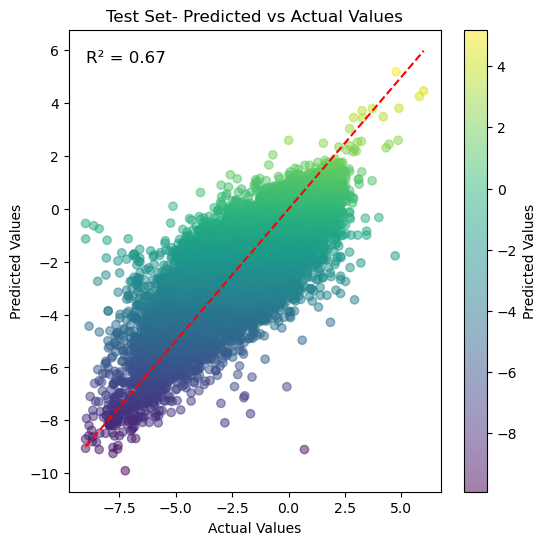

In [27]:


# Calcular o R²
r2 = r2_score(y_test_r, y_pred_test_r)

# Criar o gráfico com gradiente de cores baseado nos valores preditos
plt.figure(figsize=(6, 6))
sc = plt.scatter(y_test_r, y_pred_test_r, c=y_pred_test_r, cmap='viridis', alpha=0.5)
plt.colorbar(sc, label='Predicted Values')  # Adicionar a barra de cores

plt.plot([min(y_test_r), max(y_test_r)], [min(y_test_r), max(y_test_r)], 'r--')
plt.title('Test Set- Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Adicionar o valor do R² no gráfico
plt.text(min(y_test_r), max(y_test_r), f'R² = {r2:.2f}', fontsize=12, verticalalignment='top')

plt.show()



# My Dataset (Metz)

In [ ]:
Metz= pd.read_csv('/home/resperanca/Projeto/DeepDTA/Metz.csv')
Metz= Metz.drop_duplicates()
colunas = ['SMILES', 'ProteinSequence', 'Ki'] 
Metz = Metz.dropna(subset=colunas)
Metz= Metz.sample(frac=1).reset_index(drop=True)
Metz.to_csv('Metz_final.csv', index=False, encoding='utf-8')

In [8]:
Metz= pd.read_csv('Metz_final.csv')

In [114]:
Metz

,GeneID,Symbol,SMILES,ProteinSequence,Ki
0,103904468,MAPK13,Cc1n[nH]c2ccc(cc12)c3cncc(OC[C@@H](N)Cc4ccccc4)c3,MSLIRKKGFYKQDVNKTAWELPKTYVSPTHVGSGAYGSVCSAIDKR...,5.3
1,103904598,MARK3,COc1cc(ccc1Nc2ncc(Cl)c(Nc3ccccc3S(=O)(=O)C(C)C...,MSTRTPLPTVNERDTENHTSHGDGRQEVTSRTSRSGARCRNSIASC...,7.8
2,103905154,CSF1R,Cc1cc(OC[C@@H]2CC[C@@H](C2)C(=O)O)c(NC(=O)Nc3c...,MGPGVLLLLLVATAWHGQGIPVIEPSVPELVVKPGATVTLRCVGNG...,6.0
3,103904314,FER,Cn1cc(cn1)c2cnc(N)c3c(csc23)c4ccc(NC(=O)Nc5ccc...,MGFGSDLKNSHEAVLKLQDWELRLLETVKKFMALRIKSDKEYASTL...,6.0
4,103905503,NTRK1,Clc1ccc(cc1)C2CC(=C(C#N)C(=O)C2C(=O)c3ccccc3)c...,MLRGGRRGQLGWHSWAAGPGSLLAWLILASAGAAPCPDACCPHGSS...,6.3
...,...,...,...,...,...
35254,103904766,PRKCN,COCC(C)(C)CNc1nccc(n1)c2c(nc3c(C)nccn23)c4ccc(...,MSANNSPPSAQKSVLPTAIPAVLPAASPCSSPKTGLSARLSNGSFS...,6.2
35255,103904347,RET,Nc1nccc2scc(c3ccc(NC(=O)Nc4cccc(F)c4)cc3)c12,MAKATSGAAGLRLLLLLLLPLLGKVALGLYFSRDAYWEKLYVDQAA...,6.6
35256,103904528,GSK3A,c1cnc2nc(cn2c1)c3ccc4[nH]ncc4c3,MSGGGPSGGGPGGSGRARTSSFAEPGGGGGGGGGGPGGSASGPGGT...,7.0
35257,103904203,MELK,N[C@@H]1CC[C@H](CC1)Nc2nccc(n2)c3c[nH]c4ncccc34,MKDYDELLKYYELHETIGTGGFAKVKLACHILTGEMVAIKIMDKNT...,6.9


In [9]:
Isoniazid = {
    'Symbol': 'CHEMBL64', 
    'GeneID': 'P9WNX1', 
    'SMILES': 'NNC(=O)C1CCNCC1', 
    'ProteinSequence': 'MTMVGLIWAQATSGVIGRGGDIPWRLPEDQAHFREITMGHTIVMGRRTWDSLPAKVRPLPGRRNVVLSRQADFMASGAEVVGSLEEALTSPETWVIGGGQVYALALPYATRCEVTEVDIGLPREAGDALAPVLDETWRGETGEWRFSRSGLRYRLYSYHRS', 
}


Rifampin = {
    'Symbol': 'CHEMBL374478', 
    'GeneID': 'P9WGY9', 
    'SMILES': 'CC1C=CC=C(C(=O)NC2=C(C(=C3C(=C2O)C(=C(C4=C3C(=O)C(O4)(OC=CC(C(C(C(C(C(C1O)C)O)C)OC(=O)C)C)OC)C)C)O)O)C=NN5CCN(CC5)C)C', 
    'ProteinSequence': 'MLEGCILADSRQSKTAASPSPSRPQSSSNNSVPGAPNRVSFAKLREPLEVPGLLDVQTDSFEWLIGSPRWRESAAERGDVNPVGGLEEVLYELSPIEDFSGSMSLSFSDPRFDDVKAPVDECKDKDMTYAAPLFVTAEFINNNTGEIKSQTVFMGDFPMMTEKGTFIINGTERVVVSQLVRSPGVYFDETIDKSTDKTLHSVKVIPSRGAWLEFDVDKRDTVGVRIDRKRRQPVTVLLKALGWTSEQIVERFGFSEIMRSTLEKDNTVGTDEALLDIYRKLRPGEPPTKESAQTLLENLFFKEKRYDLARVGRYKVNKKLGLHVGEPITSSTLTEEDVVATIEYLVRLHEGQTTMTVPGGVEVPVETDDIDHFGNRRLRTVGELIQNQIRVGMSRMERVVRERMTTQDVEAITPQTLINIRPVVAAIKEFFGTSQLSQFMDQNNPLSGLTHKRRLSALGPGGLSRERAGLEVRDVHPSHYGRMCPIETPEGPNIGLIGSLSVYARVNPFGFIETPYRKVVDGVVSDEIVYLTADEEDRHVVAQANSPIDADGRFVEPRVLVRRKAGEVEYVPSSEVDYMDVSPRQMVSVATAMIPFLEHDDANRALMGANMQRQAVPLVRSEAPLVGTGMELRAAIDAGDVVVAEESGVIEEVSADYITVMHDNGTRRTYRMRKFARSNHGTCANQCPIVDAGDRVEAGQVIADGPCTDDGEMALGKNLLVAIMPWEGHNYEDAIILSNRLVEEDVLTSIHIEEHEIDARDTKLGAEEITRDIPNISDEVLADLDERGIVRIGAEVRDGDILVGKVTPKGETELTPEERLLRAIFGEKAREVRDTSLKVPHGESGKVIGIRVFSREDEDELPAGVNELVRVYVAQKRKISDGDKLAGRHGNKGVIGKILPVEDMPFLADGTPVDIILNTHGVPRRMNIGQILETHLGWCAHSGWKVDAAKGVPDWAARLPDELLEAQPNAIVSTPVFDGAQEAELQGLLSCTLPNRDGDVLVDADGKAMLFDGRSGEPFPYPVTVGYMYIMKLHHLVDDKIHARSTGPYSMITQQPLGGKAQFGGQRFGEMECWAMQAYGAAYTLQELLTIKSDDTVGRVKVYEAIVKGENIPEPGIPESFKVLLKELQSLCLNVEVLSSDGAAIELREGEDEDLERAAANLGINLSRNESASVEDLA', 
    
}



Pyrazinamide = {
    'Symbol': 'CHEMBL614', 
    'GeneID': 'P95029', 
    'SMILES': 'C1=CN=C(C=N1)C(=O)N', 
    'ProteinSequence': 'MTIHEHDRVSADRGGDSPHTTHALVDRLMAGEPYAVAFGGQGSAWLETLEELVSATGIETELATLVGEAELLLDPVTDELIVVRPIGFEPLQWVRALAAEDPVPSDKHLTSAAVSVPGVLLTQIAATRALARQGMDLVATPPVAMAGHSQGVLAVEALKAGGARDVELFALAQLIGAAGTLVARRRGISVLGDRPPMVSVTNADPERIGRLLDEFAQDVRTVLPPVLSIRNGRRAVVITGTPEQLSRFELYCRQISEKEEADRKNKVRGGDVFSPVFEPVQVEVGFHTPRLSDGIDIVAGWAEKAGLDVALARELADAILIRKVDWVDEITRVHAAGARWILDLGPGDILTRLTAPVIRGLGIGIVPAATRGGQRNLFTVGATPEVARAWSSYAPTVVRLPDGRVKLSTKFTRLTGRSPILLAGMTPTTVDAKIVAAAANAGHWAELAGGGQVTEEIFGNRIEQMAGLLEPGRTYQFNALFLDPYLWKLQVGGKRLVQKARQSGAAIDGVVISAGIPDLDEAVELIDELGDIGISHVVFKPGTIEQIRSVIRIATEVPTKPVIMHVEGGRAGGHHSWEDLDDLLLATYSELRSRANITVCVGGGIGTPRRAAEYLSGRWAQAYGFPLMPIDGILVGTAAMATKESTTSPSVKRMLVDTQGTDQWISAGKAQGGMASSRSQLGADIHEIDNSASRCGRLLDEVAGDAEAVAERRDEIIAAMAKTAKPYFGDVADMTYLQWLRRYVELAIGEGNSTADTASVGSPWLADTWRDRFEQMLQRAEARLHPQDFGPIQTLFTDAGLLDNPQQAIAALLARYPDAETVQLHPADVPFFVTLCKTLGKPVNFVPVIDQDVRRWWRSDSLWQAHDARYDADAVCIIPGTASVAGITRMDEPVGELLDRFEQAAIDEVLGAGVEPKDVASRRLGRADVAGPLAVVLDAPDVRWAGRTVTNPVHRIADPAEWQVHDGPENPRATHSSTGARLQTHGDDVALSVPVSGTWVDIRFTLPANTVDGGTPVIATEDATSAMRTVLAIAAGVDSPEFLPAVANGTATLTVDWHPERVADHTGVTATFGEPLAPSLTNVPDALVGPCWPAVFAAIGSAVTDTGEPVVEGLLSLVHLDHAARVVGQLPTVPAQLTVTATAANATDTDMGRVVPVSVVVTGADGAVIATLEERFAILGRTGSAELADPARAGGAVSANATDTPRRRRRDVTITAPVDMRPFAVVSGDHNPIHTDRAAALLAGLESPIVHGMWLSAAAQHAVTATDGQARPPARLVGWTARFLGMVRPGDEVDFRVERVGIDQGAEIVDVAARVGSDLVMSASARLAAPKTVYAFPGQGIQHKGMGMEVRARSKAARKVWDTADKFTRDTLGFSVLHVVRDNPTSIIASGVHYHHPDGVLYLTQFTQVAMATVAAAQVAEMREQGAFVEGAIACGHSVGEYTALACVTGIYQLEALLEMVFHRGSKMHDIVPRDELGRSNYRLAAIRPSQIDLDDADVPAFVAGIAESTGEFLEIVNFNLRGSQYAIAGTVRGLEALEAEVERRRELTGGRRSFILVPGIDVPFHSRVLRVGVAEFRRSLDRVMPRDADPDLIIGRYIPNLVPRLFTLDRDFIQEIRDLVPAEPLDEILADYDTWLRERPREMARTVFIELLAWQFASPVRWIETQDLLFIEEAAGGLGVERFVEIGVKSSPTVAGLATNTLKLPEYAHSTVEVLNAERDAAVLFATDTDPEPEPEEDEPVAESPAPDVVSEAAPVAPAASSAGPRPDDLVFDAADATLALIALSAKMRIDQIEELDSIESITDGASSRRNQLLVDLGSELNLGAIDGAAESDLAGLRSQVTKLARTYKPYGPVLSDAINDQLRTVLGPSGKRPGAIAERVKKTWELGEGWAKHVTVEVALGTREGSSVRGGAMGHLHEGALADAASVDKVIDAAVASVAARQGVSVALPSAGSGGGATIDAAALSEFTDQITGREGVLASAARLVLGQLGLDDPVNALPAAPDSELIDLVTAELGADWPRLVAPVFDPKKAVVFDDRWASAREDLVKLWLTDEGDIDADWPRLAERFEGAGHVVATQATWWQGKSLAAGRQIHASLYGRIAAGAENPEPGRYGGEVAVVTGASKGSIAASVVARLLDGGATVIATTSKLDEERLAFYRTLYRDHARYGAALWLVAANMASYSDVDALVEWIGTEQTESLGPQSIHIKDAQTPTLLFPFAAPRVVGDLSEAGSRAEMEMKVLLWAVQRLIGGLSTIGAERDIASRLHVVLPGSPNRGMFGGDGAYGEAKSALDAVVSRWHAESSWAARVSLAHALIGWTRGTGLMGHNDAIVAAVEEAGVTTYSTDEMAALLLDLCDAESKVAAARSPIKADLTGGLAEANLDMAELAAKAREQMSAAAAVDEDAEAPGAIAALPSPPRGFTPAPPPQWDDLDVDPADLVVIVGGAEIGPYGSSRTRFEMEVENELSAAGVLELAWTTGLIRWEDDPQPGWYDTESGEMVDESELVQRYHDAVVQRVGIREFVDDGAIDPDHASPLLVSVFLEKDFAFVVSSEADARAFVEFDPEHTVIRPVPDSTDWQVIRKAGTEIRVPRKTKLSRVVGGQIPTGFDPTVWGISADMAGSIDRLAVWNMVATVDAFLSSGFSPAEVMRYVHPSLVANTQGTGMGGGTSMQTMYHGNLLGRNKPNDIFQEVLPNIIAAHVVQSYVGSYGAMIHPVAACATAAVSVEEGVDKIRLGKAQLVVAGGLDDLTLEGIIGFGDMAATADTSMMCGRGIHDSKFSRPNDRRRLGFVEAQGGGTILLARGDLALRMGLPVLAVVAFAQSFGDGVHTSIPAPGLGALGAGRGGKDSPLARALAKLGVAADDVAVISKHDTSTLANDPNETELHERLADALGRSEGAPLFVVSQKSLTGHAKGGAAVFQMMGLCQILRDGVIPPNRSLDCVDDELAGSAHFVWVRDTLRLGGKFPLKAGMLTSLGFGHVSGLVALVHPQAFIASLDPAQRADYQRRADARLLAGQRRLASAIAGGAPMYQRPGDRRFDHHAPERPQEASMLLNPAARLGDGEAYIG', 
    
}


Ethambutol = {
    'Symbol': 'CHEMBL44884', 
    'GeneID': 'P33261', 
    'SMILES': 'CCC(CO)NCCNC(CC)CO', 
    'ProteinSequence': 'MDPFVVLVLCLSCLLLLSIWRQSSGRGKLPPGPTPLPVIGNILQIDIKDVSKSLTNLSKIYGPVFTLYFGLERMVVLHGYEVVKEALIDLGEEFSGRGHFPLAERANRGFGIVFSNGKRWKEIRRFSLMTLRNFGMGKRSIEDRVQEEARCLVEELRKTKASPCDPTFILGCAPCNVICSIIFQKRFDYKDQQFLNLMEKLNENIRIVSTPWIQICNNFPTIIDYFPGTHNKLLKNLAFMESDILEKVKEHQESMDINNPRDFIDCFLIKMEKEKQNQQSEFTIENLVITAADLLGAGTETTSTTLRYALLLLLKHPEVTAKVQEEIERVVGRNRSPCMQDRGHMPYTDVVHEVQRYIDIPTSLPHAVTCDVKRNYLPKGTTILTSLTSVLHDNKEFPNPEMFDPRHFLDEGGNFKKSNYFMPFSAGKRICVGEGLARMELFLFLTFILQNFNLKSLIDPKDLDTTPVVNGFASVPPFYQLCFIPV', 
    
}


Streptomycin = {
    'Symbol': 'CHEMBL372795', 
    'GeneID': 'Q9UM07', 
    'SMILES': 'CC1C(C(C(O1)OC2C(C(C(C(C2O)O)N=C(N)N)O)N=C(N)N)OC3C(C(C(C(O3)CO)O)O)NC)(C=O)O', 
    'ProteinSequence': 'MAQGTLIRVTPEQPTHAVCVLGTLTQLDICSSAPEDCTSFSINASPGVVVDIAHGPPAKKKSTGSSTWPLDPGVEVTLTMKVASGSTGDQKVQISYYGPKTPPVKALLYLTGVEISLCADITRTGKVKPTRAVKDQRTWTWGPCGQGAILLVNCDRDNLESSAMDCEDDEVLDSEDLQDMSLMTLSTKTPKDFFTNHTLVLHVARSEMDKVRVFQATRGKLSSKCSVVLGPKWPSHYLMVPGGKHNMDFYVEALAFPDTDFPGLITLTISLLDTSNLELPEAVVFQDSVVFRVAPWIMTPNTQPPQEVYACSIFENEDFLKSVTTLAMKAKCKLTICPEEENMDDQWMQDEMEIGYIQAPHKTLPVVFDSPRNRGLKEFPIKRVMGPDFGYVTRGPQTGGISGLDSFGNLEVSPPVTVRGKEYPLGRILFGDSCYPSNDSRQMHQALQDFLSAQQVQAPVKLYSDWLSVGHVDEFLSFVPAPDRKGFRLLLASPRSCYKLFQEQQNEGHGEALLFEGIKKKKQQKIKNILSNKTLREHNSFVERCIDWNRELLKRELGLAESDIIDIPQLFKLKEFSKAEAFFPNMVNMLVLGKHLGIPKPFGPVINGRCCLEEKVCSLLEPLGLQCTFINDFFTYHIRHGEVHCGTNVRRKPFSFKWWNMVP', 
    
}



Ethionamide = {
    'Symbol': 'CHEMBL1441',  
    'GeneID': 'P9WGR1', 
    'SMILES': 'CCC1=NC=CC(=C1)C(=S)N', 
    'ProteinSequence': 'MTGLLDGKRILVSGIITDSSIAFHIARVAQEQGAQLVLTGFDRLRLIQRITDRLPAKAPLLELDVQNEEHLASLAGRVTEAIGAGNKLDGVVHSIGFMPQTGMGINPFFDAPYADVSKGIHISAYSYASMAKALLPIMNPGGSIVGMDFDPSRAMPAYNWMTVAKSALESVNRFVAREAGKYGVRSNLVAAGPIRTLAMSAIVGGALGEEAGAQIQLLEEGWDQRAPIGWNMKDATPVAKTVCALLSDWLPATTGDIIYADGGAHTQLL', 
    
}



Kanamycin = {
    'Symbol': 'CHEMBL1384',  
    'GeneID': 'P0A7S3', 
    'SMILES': 'C1C(C(C(C(C1N)OC2C(C(C(C(O2)CN)O)O)O)O)OC3C(C(C(C(O3)CO)O)N)O)N', 
    'ProteinSequence': 'MATVNQLVRKPRARKVAKSNVPALEACPQKRGVCTRVYTTTPKKPNSALRKVCRVRLTNGFEVTSYIGGEGHNLQEHSVILIRGGRVKDLPGVRYHTVRGALDCSGVKDRKQARSKYGVKRPKA', 
    
}



new_row = pd.DataFrame([Isoniazid, Pyrazinamide, Ethambutol ])


merged = pd.concat([Metz, new_row], ignore_index=True) 

tamanho_proteinas = merged['ProteinSequence']
tamanho_proteinas = [len(seq) for seq in tamanho_proteinas]


tamanho_smiles = merged['SMILES']
tamanho_smiles = [len(seq) for seq in tamanho_smiles]

sorted_tamanho_proteinas = sorted(tamanho_proteinas)
sorted_tamanho_smiles = sorted(tamanho_smiles)

#get the 95% percentile
tamanho_proteinas = sorted_tamanho_proteinas[int(len(sorted_tamanho_proteinas)*0.95)]
tamanho_smiles = sorted_tamanho_smiles[int(len(sorted_tamanho_smiles)*0.95)]

tamanho_proteinas, tamanho_smiles
     

(1392, 66)

In [10]:
import math

def safe_log10(x):
    if x > 0:
        return -math.log10(x)
    else:
        return float('0')  

merged['Ki'] = pd.to_numeric(merged['Ki'], errors='coerce')


merged['Ki'] = merged['Ki'].apply(safe_log10)

In [12]:
PROT_LEN = 1392
SMILE_LEN = 66


def label_smiles(line, MAX_SMI_LEN, CHAR_SMILE_SET):
	X = np.zeros(MAX_SMI_LEN)
	for i, ch in enumerate(line[:MAX_SMI_LEN]): #	x, smi_ch_ind, y
		X[i] = CHAR_SMILE_SET[ch]

	return X #.tolist()

def label_sequence(line, MAX_SEQ_LEN, CHAR_PROT_SET):
	X = np.zeros(MAX_SEQ_LEN)

	for i, ch in enumerate(line[:MAX_SEQ_LEN]):
		X[i] = CHAR_PROT_SET[ch]

	return X #.tolist()

encoded_data_merged= {'x_prot':[], 'x_met':[]}

for i, (index, row) in enumerate(merged.iterrows()):
     print('percentage: {0:.3%}'.format(i/merged.shape[0]), end='\r')
     encoded_data_merged['x_prot'].append(label_sequence(row['ProteinSequence'], PROT_LEN, CHAR_PROT_SET))
     encoded_data_merged['x_met'].append(label_smiles(row['SMILES'], SMILE_LEN, CHAR_SMILE_SET))


In [13]:
if select_gpus:
    with strategy.scope():
        model = DeepDTA(PROT_LEN, SMILE_LEN, len(CHAR_SMILE_SET), len(CHAR_PROT_SET), 32)

else:
    model = DeepDTA(PROT_LEN, SMILE_LEN, len(CHAR_SMILE_SET), len(CHAR_PROT_SET), 32)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 66)]                 0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 1392)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 66, 128)              8448      ['input_2[0][0]']             
                                                                                                  
 embedding (Embedding)       (None, 1392, 128)            6400      ['input_1[0][0]']             
                                                                                              

In [14]:
x_prot_M = encoded_data_merged['x_prot']
x_met_M = encoded_data_merged['x_met']

x_prot_test_M = np.array(x_prot_M)
x_met_test_M = np.array(x_met_M)

In [15]:
model.load_weights('binding_checkpoint_clean_dataset.h5')
y_pred_test_M = model.predict([x_prot_test_M, x_met_test_M], verbose=0)

2024-06-16 19:13:10.484478: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2024-06-16 19:13:11.316404: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-16 19:13:11.859685: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [16]:

drug_column = 'Symbol'
target_column = 'GeneID'


drogas_test = merged[drug_column]
proteinas_test = merged[target_column]
valores_previsoes = y_pred_test_M.flatten() 

import pandas as pd


data = {'Drug': drogas_test, 'Protein': proteinas_test, 'Prediction': valores_previsoes}
df = pd.DataFrame(data)

# Construir a matriz de interação droga-alvo usando pivot_table
interaction_matrix_D = df.pivot_table(index='Drug', columns='Protein', values='Prediction', aggfunc='first')

interaction_matrix_D = interaction_matrix_D.fillna(0)

# Mostrar a matriz de interação
print("\nMatriz de interação droga-alvo:")
print(interaction_matrix_D)


Matriz de interação droga-alvo:
Protein  103904189  103904190  103904191  103904192  103904194  103904195  \
Drug                                                                        
ABL1     -2.285035  -2.278337  -2.885677  -2.848510  -2.578937  -2.755012   
ACK1     -1.669065  -1.654786   0.000000   0.000000   0.000000   0.000000   
ACVR1    -2.681766  -2.633964  -3.432886   0.000000   0.000000   0.000000   
AKT1     -1.689451   0.000000  -3.068107  -2.355928   0.000000   0.000000   
AKT2     -2.119883   0.000000   0.000000   0.000000   0.000000   0.000000   
...            ...        ...        ...        ...        ...        ...   
TOPK     -2.539996   0.000000  -3.610177  -2.998034   0.000000  -3.438626   
TYK2     -1.855555   0.000000   0.000000  -1.703704   0.000000   0.000000   
TYRO3     0.000000  -2.745726   0.000000   0.000000   0.000000   0.000000   
WEE1      0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
ZAK       0.000000   0.000000  -3.617073  -

In [17]:
id_procurado = 'CHEMBL614'
linha = interaction_matrix_D.loc[id_procurado]
print(linha)

Valores correspondentes ao ID procurado:
Protein
103904189    0.000000
103904190    0.000000
103904191    0.000000
103904192    0.000000
103904194    0.000000
               ...   
103905684    0.000000
103905685    0.000000
P33261       0.000000
P95029      -5.143974
P9WNX1       0.000000
Name: CHEMBL614, Length: 1426, dtype: float32


# Clustering

In [21]:
interaction_matrix_D.columns = interaction_matrix_D.columns.astype(str)

A interação entre a droga CHEMBL64 e o target P9WNX1 é: -2.6302597522735596


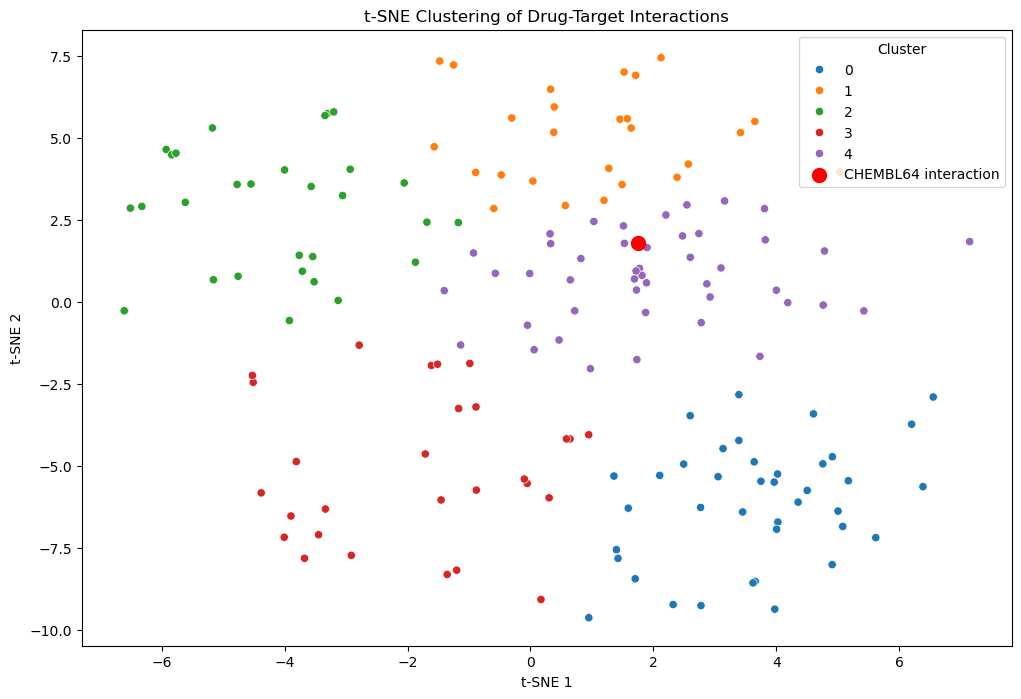

In [22]:
# Aplicar t-SNE na matriz de interação
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(interaction_matrix_D)

# Adicionar os resultados t-SNE ao DataFrame
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['Drug'] = interaction_matrix_D.index

kmeans = KMeans(n_clusters=5, random_state=0).fit(tsne_results)
tsne_df['Cluster'] = kmeans.labels_

drug_to_highlight = 'CHEMBL64'
target_to_highlight = 'P9WNX1'

# Verificar se a droga e o target estão presentes na matriz de interação
if drug_to_highlight in interaction_matrix_D.index and target_to_highlight in interaction_matrix_D.columns:
    interaction_value = interaction_matrix_D.loc[drug_to_highlight, target_to_highlight]
    print(f"A interação entre a droga {drug_to_highlight} e o target {target_to_highlight} é: {interaction_value}")

    # Encontrar o ponto específico no DataFrame t-SNE
    highlight_point = tsne_df[tsne_df['Drug'] == drug_to_highlight]
    
    # Visualizar os resultados t-SNE com clusters e destacar a droga especificada
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='TSNE1', y='TSNE2', data=tsne_df, hue='Cluster', palette='tab10')
    plt.scatter(highlight_point['TSNE1'], highlight_point['TSNE2'], color='red', s=100, label=f'{drug_to_highlight} interaction')
    plt.title('t-SNE Clustering of Drug-Target Interactions')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend(title='Cluster')
    plt.show()

In [25]:
highlight_cluster = highlight_point['Cluster'].values[0]


In [26]:
drugs_in_cluster = tsne_df[tsne_df['Cluster'] == highlight_cluster]['Drug'].values


In [27]:
interactions_in_cluster = {}
for drug in drugs_in_cluster:
    if drug in interaction_matrix_D.index and target_to_highlight in interaction_matrix_D.columns:
        interaction_value = interaction_matrix_D.loc[drug, target_to_highlight]
        interactions_in_cluster[drug] = interaction_value


In [28]:
print(f"Drogas presentes no cluster onde está o ponto destacado ({highlight_cluster}):")
for drug, interaction_value in interactions_in_cluster.items():
    print(f"Droga: {drug}, Interação: {interaction_value}")


Drogas presentes no cluster onde está o ponto destacado (4):
Droga: AXL, Interação: 0.0
Droga: CAMK1, Interação: 0.0
Droga: CAMKK2, Interação: 0.0
Droga: CDC2L6, Interação: 0.0
Droga: CHEK2, Interação: 0.0
Droga: CHEMBL44884, Interação: 0.0
Droga: CHEMBL614, Interação: 0.0
Droga: CHEMBL64, Interação: -2.6302597522735596
Droga: CHUK, Interação: 0.0
Droga: DCAMKL1, Interação: 0.0
Droga: EEF2K, Interação: 0.0
Droga: EGFR, Interação: 0.0
Droga: EPHA2, Interação: 0.0
Droga: ERBB2, Interação: 0.0
Droga: ERBB4, Interação: 0.0
Droga: FER, Interação: 0.0
Droga: FES, Interação: 0.0
Droga: FGFR3, Interação: 0.0
Droga: FRK, Interação: 0.0
Droga: HCK, Interação: 0.0
Droga: IGF1R, Interação: 0.0
Droga: IKBKB, Interação: 0.0
Droga: INSR, Interação: 0.0
Droga: ITK, Interação: 0.0
Droga: KIT, Interação: 0.0
Droga: LIMK1, Interação: 0.0
Droga: MAP3K10, Interação: 0.0
Droga: MAPK10, Interação: 0.0
Droga: MARK4, Interação: 0.0
Droga: MATK, Interação: 0.0
Droga: MELK, Interação: 0.0
Droga: NEK2, Interação:

In [29]:


distances = {}
for index, row in tsne_df.iterrows():
    point = (row['TSNE1'], row['TSNE2'])
    distance = euclidean(point, (highlight_point['TSNE1'].values[0], highlight_point['TSNE2'].values[0]))
    distances[row['Drug']] = distance


In [30]:
closest_drug = min(distances, key=distances.get)
closest_distance = distances[closest_drug]


In [31]:
distances = {}
for index, row in tsne_df.iterrows():
    point = (row['TSNE1'], row['TSNE2'])
    distance = euclidean(point, (highlight_point['TSNE1'].values[0], highlight_point['TSNE2'].values[0]))
    distances[row['Drug']] = distance

closest_drugs = sorted(distances, key=distances.get)[1:5]

print("As 5 drogas mais próximas do ponto destacado são:")
for i, drug in enumerate(closest_drugs, 1):
    print(f"{i}. Droga: {drug}, Distância euclidiana: {distances[drug]}")


As 5 drogas mais próximas do ponto destacado são:
1. Droga: CHEMBL614, Distância euclidiana: 0.030449183781178404
2. Droga: CHEMBL44884, Distância euclidiana: 0.03412441741754673
3. Droga: STK33, Distância euclidiana: 0.07781715863156087
4. Droga: WEE1, Distância euclidiana: 0.21171957758280477


As 5 drogas mais próximas do ponto destacado são:
1. Droga: CHEMBL64, Distância euclidiana: 0.0
2. Droga: CHEMBL614, Distância euclidiana: 0.030449183781178404
3. Droga: CHEMBL44884, Distância euclidiana: 0.03412441741754673
4. Droga: STK33, Distância euclidiana: 0.07781715863156087
5. Droga: WEE1, Distância euclidiana: 0.21171957758280477


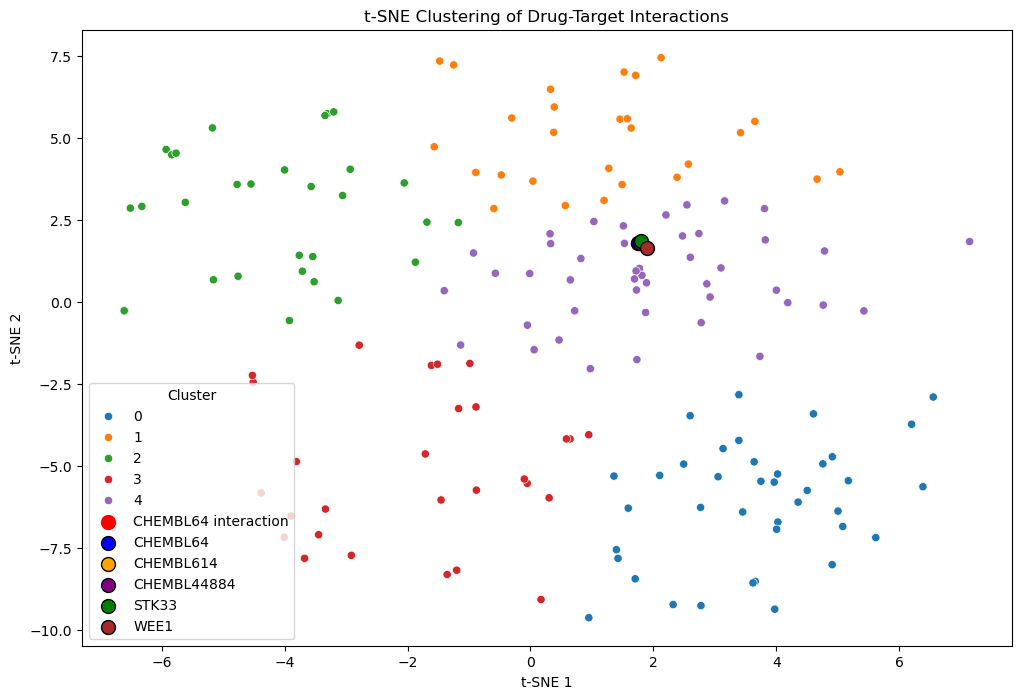

In [32]:


# Calcular todas as distâncias euclidianas entre o ponto destacado e todas as outras drogas
distances = {}
for index, row in tsne_df.iterrows():
    point = (row['TSNE1'], row['TSNE2'])
    distance = euclidean(point, (highlight_point['TSNE1'].values[0], highlight_point['TSNE2'].values[0]))
    distances[row['Drug']] = distance

# Obter as 5 drogas mais próximas
closest_drugs = sorted(distances, key=distances.get)[:5]

# Imprimir os resultados
print("As 5 drogas mais próximas do ponto destacado são:")
for i, drug in enumerate(closest_drugs, 1):
    print(f"{i}. Droga: {drug}, Distância euclidiana: {distances[drug]}")

# Definir uma lista de cores
colors = ['blue', 'orange', 'purple', 'green', 'brown']

# Plotar o gráfico t-SNE com clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='TSNE1', y='TSNE2', data=tsne_df, hue='Cluster', palette='tab10')

# Destacar o ponto específico no gráfico
plt.scatter(highlight_point['TSNE1'], highlight_point['TSNE2'], color='red', s=100, label=f'{drug_to_highlight} interaction')

# Destacar as 5 drogas mais próximas com cores diferentes
for i, drug in enumerate(closest_drugs):
    closest_point = tsne_df[tsne_df['Drug'] == drug]
    plt.scatter(closest_point['TSNE1'], closest_point['TSNE2'], color=colors[i], s=100, edgecolor='black', label=f'{drug}')

plt.title('t-SNE Clustering of Drug-Target Interactions')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Cluster')
plt.show()